# Import Data

In [1]:
SMALL_SIZE, MEDIUM_SIZE = 9, 12
PROJECT_PATH = "/Users/donghur/Desktop/Research/Murthy/BM_GPU"
PROJECT_PATH_BMGPU = "/Users/donghur/Desktop/Research/Murthy/BM_GPU"

In [2]:
import sys
import numpy as np
from glob import glob
import random, matplotlib
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

sys.path.append(PROJECT_PATH)
from utils.data import Dataset


In [3]:
import utils.figure as ufigure
%load_ext autoreload
%autoreload 1
%aimport utils.data
%aimport utils.figure

In [4]:
config_path = f"{PROJECT_PATH_BMGPU}/config_ant.yaml"
Data = Dataset(PROJECT_PATH, config_path)
Data.load_data()

  0%|          | 0/141 [00:00<?, ?it/s]

Loading config.yaml ...
Finished loading config
Loading INFO.yaml ...
Finished loading INFO


100%|██████████| 141/141 [00:34<00:00,  4.07it/s]


In [5]:
# configuration
INFO = Data.info
INFO_values = Data.info_values
config = Data.config
skeleton = config['skeleton']
skeleton_color= config['skeleton_color']

# features
bp = Data.data_obj['bodypoints']
rot_bp = Data.data_obj['rotated_bodypoints']
angles = Data.data_obj['angles']
limbs = Data.data_obj['limbs']
angle_power = Data.data_obj['angle_power']
limb_power = Data.data_obj['limb_power']

# embeddings
all_embed = Data.data_obj['all_embeddings']
all_postural_embed = Data.data_obj['all_postural_embeddings']
all_kinematic_embed = Data.data_obj['all_kinematic_embeddings']

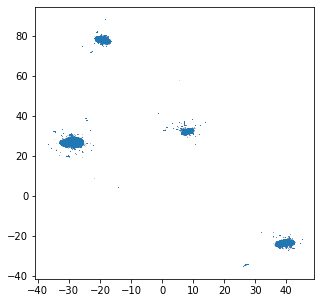

In [6]:
fig_all_embed, ax_all_embed = plt.subplots(1,1,figsize=(5,5))
ax_all_embed.scatter(all_postural_embed[:,0], all_postural_embed[:,1], s=1, alpha=0.005)
plt.show()

# Quick Overview

In [7]:
# Global parameter for the rest of the embeddings
ax_x_length = np.diff(ax_all_embed.get_xlim())[0]
ax_y_length = np.diff(ax_all_embed.get_ylim())[0]

def fix_aspect_ratio(xlim, ylim):
    d = np.diff(xlim)[0]*ax_y_length/ax_x_length - np.diff(ylim)[0]
    return xlim, (ylim[0]-d/2, ylim[1]+d/2)

def plot_embedding(embed, xlim, ylim, frac_pts=1/3, scatter_s=1, scatter_alpha=0.04, kde_gridsize=200):
    num_fr = len(embed)
    idx = random.choices(np.arange(num_fr), k=int(num_fr*frac_pts))
    
    # Scatter Plot
    fig, ax = plt.subplots(1,2,figsize=(20,10))
    ax[0].scatter(embed[idx,0], embed[idx,1], s=scatter_s, alpha=scatter_alpha)
    ax[0].set(xlabel='UMAP C1', ylabel='UMAP C2', title="All Postural Features Embedding", xlim=xlim,ylim=ylim)

    # Density Plot
    sns.kdeplot(x=embed[idx,0], y=embed[idx,1], 
                shade=True, thresh=0, gridsize=kde_gridsize, bw_adjust=0.3,
                levels=100, cmap='viridis',
                cbar=False, ax=ax[1])
    ax[1].set(xlabel='UMAP C1', ylabel='UMAP C2', title="All Postural Features Embedding", facecolor='#440054', 
                        xlim=xlim ,ylim=ylim)
    plt.show()

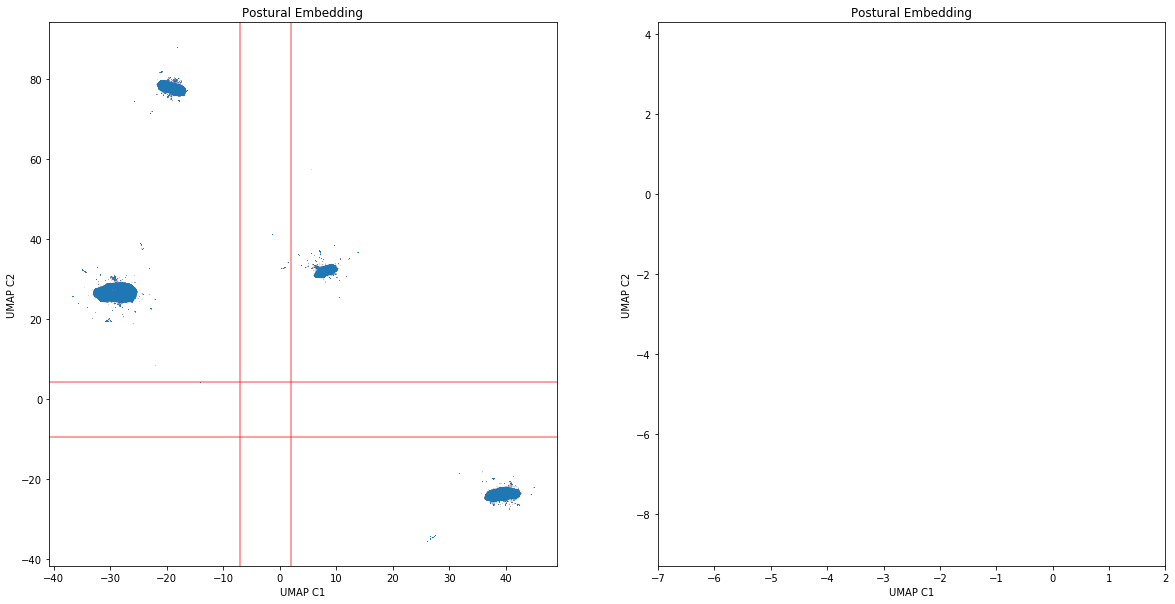

In [8]:
region_x_lim, region_y_lim = (-7,2), (-10,5)
region_x_lim, region_y_lim = fix_aspect_ratio(region_x_lim, region_y_lim)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].scatter(all_postural_embed[:,0], all_postural_embed[:,1], s=1, alpha=0.005)
ax[0].set(xlabel="UMAP C1", ylabel="UMAP C2", title="Postural Embedding")
for x,y in zip(region_x_lim, region_y_lim):
    ax[0].axhline(y=y, color='r', alpha=0.5)
    ax[0].axvline(x=x, color='r', alpha=0.5)
ax[1].scatter(all_postural_embed[:,0], all_postural_embed[:,1], s=2, alpha=0.006)
ax[1].set(xlabel="UMAP C1", ylabel="UMAP C2", title="Postural Embedding",xlim=region_x_lim, ylim=region_y_lim)
plt.show()

# Posture Snapshot

In [9]:
import seaborn as sns
from sklearn.utils import shuffle

from utils.figure import plot_HDBSCAN
from cluster import HDBSCAN
%aimport cluster

In [14]:
labels, num_clusters, clusterer = HDBSCAN(all_postural_embed, min_cluster_size=3000, min_samples=20, 
                               cluster_selection_epsilon=0, cluster_selection_method="leaf", 
                               memory="memory")
color_palette = sns.color_palette('rainbow', int(num_clusters))
color_palette = shuffle(color_palette, random_state=1)

Frac Outlier: 0.14538564998947728
# Clusters: 20


100%|██████████| 20/20 [00:00<00:00, 9657.62it/s]


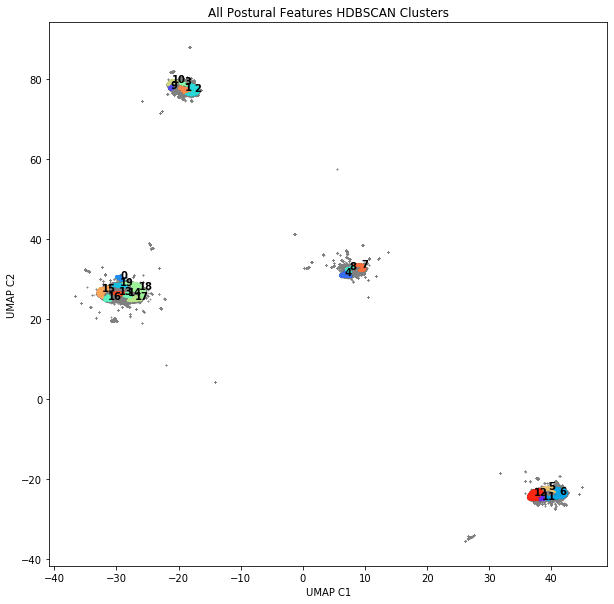

In [15]:
region_x_lim, region_y_lim = (-23,7), (-5,25)
region_x_lim, region_y_lim = fix_aspect_ratio(region_x_lim, region_y_lim)

fig, ax = plt.subplots(figsize=(10,10))
plot_HDBSCAN(ax, all_postural_embed, labels, color_palette, marker_size=0.2, alpha=0.2, toggle_numbering=True)
plt.show()
# plot_HDBSCAN(ax, all_postural_embed, labels, color_palette, marker_size=0.05, alpha=0.06, toggle_numbering=True, xlim=region_x_lim, ylim=region_y_lim)
# plt.show()

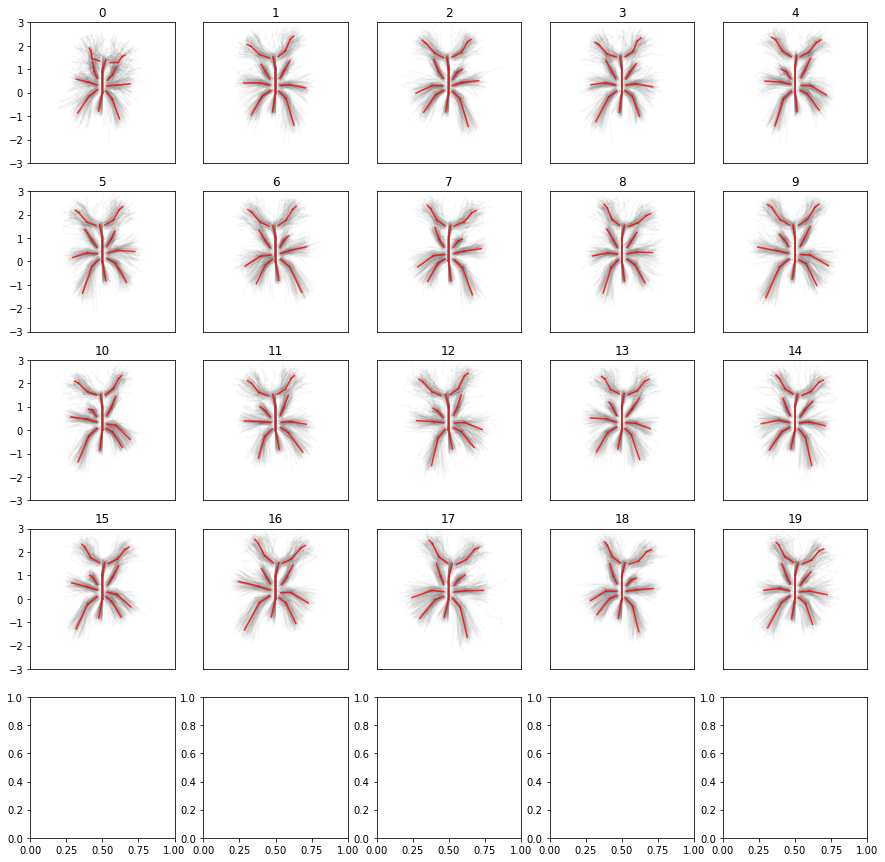

In [19]:
num_cluster = int(np.max(labels)+1)

num_columns = 5
num_rows = num_cluster//num_columns+1
fig, ax = plt.subplots(num_rows, num_columns, figsize=(3*num_rows,3*num_columns))

for i in tqdm(range(num_cluster)):
    idx = np.where(labels==i)[0]
    rand_idx = random.choices(idx, k=100)
    # sample skeleton (gray)
    for fr in rand_idx:
        for skeleton_i in skeleton:
            ax[i//num_columns,i%num_columns].plot(rot_bp[fr,skeleton_i,0], rot_bp[fr,skeleton_i,1], c='gray', alpha=0.05)
    # average skeleton (red)
    avg_rot_bp = np.mean(rot_bp[rand_idx,:,:], axis=0)
    for skeleton_i in skeleton:
        avg_rot_bp = np.mean(rot_bp[rand_idx,:,:], axis=0)
        ax[i//num_columns,i%num_columns].plot(avg_rot_bp[skeleton_i,0], avg_rot_bp[skeleton_i,1], c='red', alpha=0.8)
    # figure labels
    ax[i//num_columns,i%num_columns].set(title=f"{i}", xlim=(-3,3), ylim=(-3,3))
    if i%num_columns != 0:
        ax[i//num_columns,i%num_columns].yaxis.set_visible(False)
    if i//num_columns != num_rows:
        ax[i//num_columns,i%num_columns].xaxis.set_visible(False)